# Text classification with an RNN

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2J3TLP/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2J3TLP/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2J3TLP/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"This show is unbelievable in that . . . what it represents and what it focuses on and . . . words cannot describe how insane ET is. They will report anything. If a celebrity is even remotely indirectly connected to the story ET will report on it. If a dog poop in the Tom Cruise's yard they will report on it. If a celebrity dies . . . they will talk about it for weeks on end to the point where the public envy that celebrity. If a celebrity is on trial . . . ET will report it for MONTHS on end. There is no end to what this show will reports and no time frame that dictates how long they will focus on a story. Is it even considered legitimates reporting? The reports are so dang annoying too, with harsh rambling voices and end with an unnecessary pause to convey a sense of important. I cannot watch this show without questioning humanity's existence. ET is one big reason I avoid pre-evening shows in general. I regret that IMDb can only allow a minimum of one star rating and not ze

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11, 120,   7, ...,   0,   0,   0],
       [ 90,  76,  70, ...,   0,   0,   0],
       [ 87,  69,  35, ...,   0,   0,   0]])

In [ ]:
print(encoded_example.shape)

(3, 995)


With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"This show is unbelievable in that . . . what it represents and what it focuses on and . . . words cannot describe how insane ET is. They will report anything. If a celebrity is even remotely indirectly connected to the story ET will report on it. If a dog poop in the Tom Cruise's yard they will report on it. If a celebrity dies . . . they will talk about it for weeks on end to the point where the public envy that celebrity. If a celebrity is on trial . . . ET will report it for MONTHS on end. There is no end to what this show will reports and no time frame that dictates how long they will focus on a story. Is it even considered legitimates reporting? The reports are so dang annoying too, with harsh rambling voices and end with an unnecessary pause to convey a sense of important. I cannot watch this show without questioning humanity's existence. ET is one big reason I avoid pre-evening shows in general. I regret that IMDb can only allow a minimum of one star rating and not 

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [ ]:
# this is sequential API
model = tf.keras.Sequential([
    encoder, # this converts text into numbers
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True), # process numbers into vectors
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), # notice we have an LSTM and it is inside a bi-directional RNN
    tf.keras.layers.Dense(64, activation='relu'), # hidden layer has 64 neurons
    tf.keras.layers.Dense(1) # output has 1 neuron => this predicts 1 or 0
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-trai

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [ ]:
# predict on a sample text without padding.
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
np.array([sample_text])

array(['The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.'],
      dtype='<U104')

In [ ]:
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.00056616]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.00056616]


Compile the Keras model to configure the training process:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [ ]:
# cpu: central processing unit
# gpu: graphical processing unit
device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(train_dataset, epochs=5,
                      validation_data=test_dataset,
                      validation_steps=30)

Epoch 1/5
391/391 [==============================] - 41s 87ms/step - loss: 0.6494 - accuracy: 0.5505 - val_loss: 0.5129 - val_accuracy: 0.6932
Epoch 2/5
391/391 [==============================] - 33s 82ms/step - loss: 0.4338 - accuracy: 0.7921 - val_loss: 0.4077 - val_accuracy: 0.8234
Epoch 3/5
391/391 [==============================] - 33s 83ms/step - loss: 0.3609 - accuracy: 0.8407 - val_loss: 0.3496 - val_accuracy: 0.8479
Epoch 4/5
391/391 [==============================] - 33s 83ms/step - loss: 0.3318 - accuracy: 0.8574 - val_loss: 0.3321 - val_accuracy: 0.8583
Epoch 5/5
391/391 [==============================] - 33s 83ms/step - loss: 0.3168 - accuracy: 0.8648 - val_loss: 0.3300 - val_accuracy: 0.8609


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 15s 39ms/step - loss: 0.3227 - accuracy: 0.8645
Test Loss: 0.3227291405200958
Test Accuracy: 0.8644800186157227


(0.0, 0.6660663470625877)

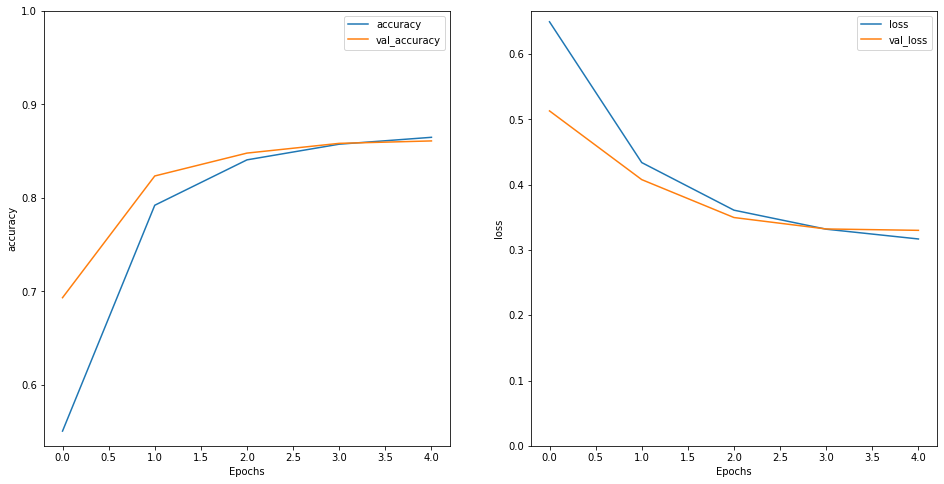

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
np.array([sample_text])

array(['The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.'],
      dtype='<U104')

In [ ]:
predictions = model.predict(np.array([sample_text]))

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)), # rnn hidden layer 1
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), # rnn hidden layer 2
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(train_dataset, epochs=5,
                      validation_data=test_dataset,
                      validation_steps=30)

Epoch 1/5
391/391 [==============================] - 75s 157ms/step - loss: 0.5898 - accuracy: 0.6260 - val_loss: 0.3956 - val_accuracy: 0.8266
Epoch 2/5
391/391 [==============================] - 58s 147ms/step - loss: 0.3729 - accuracy: 0.8389 - val_loss: 0.3530 - val_accuracy: 0.8542
Epoch 3/5
391/391 [==============================] - 58s 148ms/step - loss: 0.3315 - accuracy: 0.8590 - val_loss: 0.3448 - val_accuracy: 0.8339
Epoch 4/5
391/391 [==============================] - 58s 146ms/step - loss: 0.3156 - accuracy: 0.8645 - val_loss: 0.3664 - val_accuracy: 0.8547
Epoch 5/5
391/391 [==============================] - 58s 148ms/step - loss: 0.3113 - accuracy: 0.8694 - val_loss: 0.3179 - val_accuracy: 0.8594


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 27s 69ms/step - loss: 0.3124 - accuracy: 0.8604
Test Loss: 0.3123689591884613
Test Accuracy: 0.8604000210762024


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-1.5455756]]


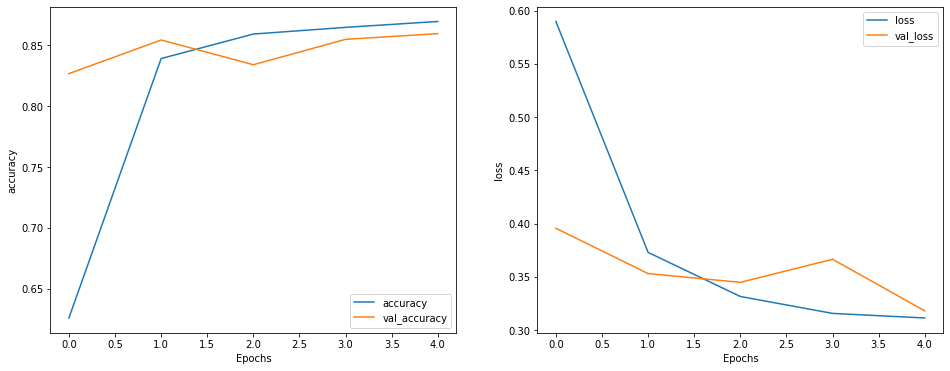

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
